## Градиентный спуск для линейной регрессии

In [ ]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

#### 1. Градиентный спуск

Самый простой функционал ошибки, применяемый в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса линейной модели.

В матричном виде (для линейной модели):

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — матрица объекты-признаки, а $y$ — вектор правильных ответов.

Градиент функционала MSE:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [ ]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

**1.1 Реализация класса `MSELoss`**

In [ ]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        return np.square(X.dot(w) - y).mean()

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w (значения вектора градиента)
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        return 2 * X.T.dot(X.dot(w) - y) / X.shape[0]

In [ ]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Формула для одной итерации градиентного спуска:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**1.2 Реализация функции `gradient_descent`**

In [ ]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = w_init
    w_trajectory = []
    # цикл, в котором происходит шаг градиентного спуска
    for i in range(n_iterations):
      grad = loss.calc_grad(X, y, w)                                              # считаем градиент в исходной точке
      w = w - lr * grad                                                           # делаем шаг в сторону антиградиента, получаем новые веса
      w_trajectory.append(w)                                                      # запоминаем новые веса
    return w_trajectory                                                           # возвращаем траекторию спуска (список из новых значений весов на каждом шаге)

In [ ]:
# Создаём синтетический датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [ ]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

155.2625821435192
0.8670644395649493


In [ ]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска по истории
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**1.3 Отрисовка траектории градиентного спуска для разных значений длины шага**

Learning rate =  0.0001


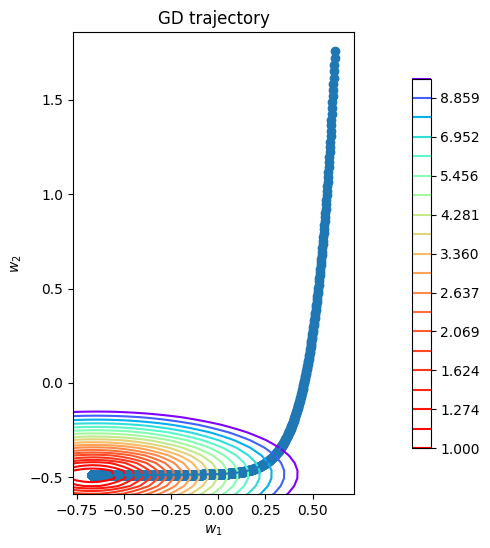


Learning rate =  0.0005


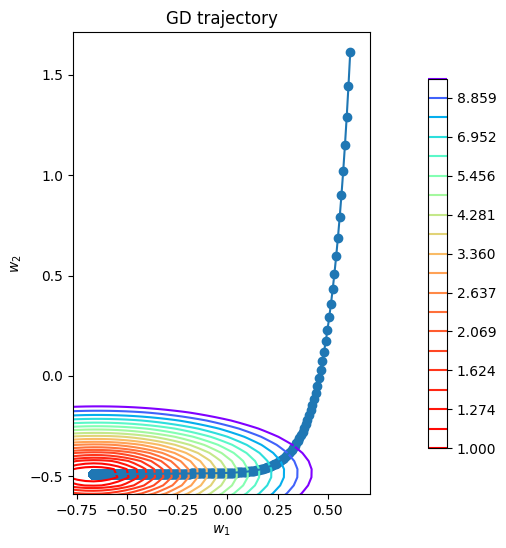


Learning rate =  0.001


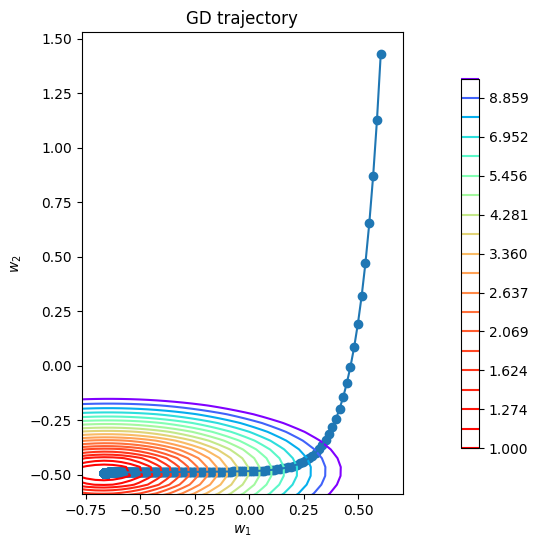


Learning rate =  0.005


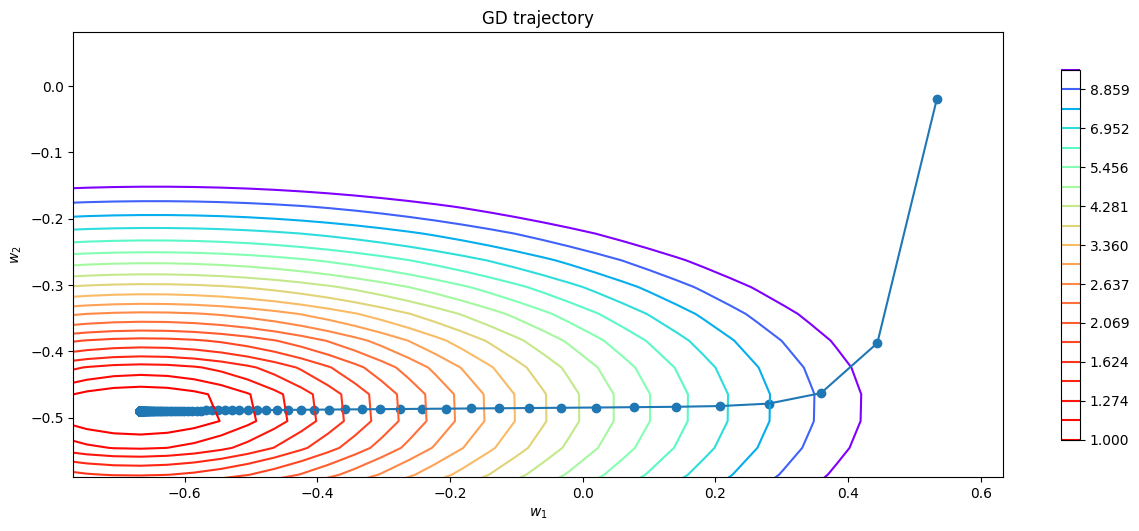


Learning rate =  0.01


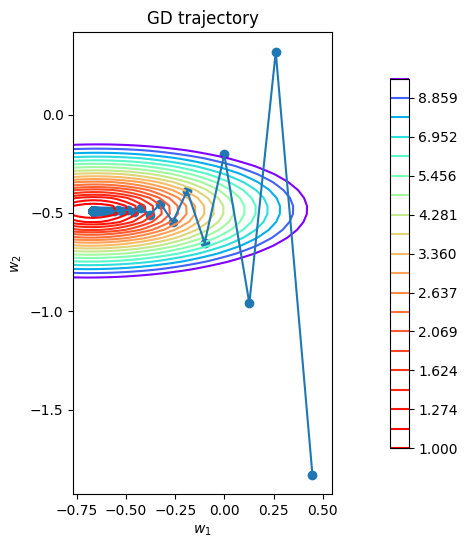

In [ ]:
for lr in [0.0001, 0.0005, 0.001, 0.005, 0.01]:
  w_list = gradient_descent(w_init, X, y, MSELoss(), lr)
  print('Learning rate = ', lr)
  plot_gd(w_list, X, y, MSELoss())
  print()

Влияние параметра lr (длины шага) на поведение градиентного спуска:

- можно заметить, что при увеличении длины шага, на графике уменьшается количество точек-"остановок" (делаем меньше шагов и быстрее находим точку минимума)
- однако при этом траектория градиентного спуска становится менее гладкой (особенно это заметно при сравнении первого и последнего графиков)
- при увеличении lr траектория спуска начинает становиться ломаной (при lr = 0.01 траектория сначала сильно колеблется, его метает из стороны в сторону)
- при маленьких значениях lr спуск очень медленный и на траектории очень много точек и, если сделать количество итераций меньшим, то градиентный спуск может даже не дойти до минимума
- а при очень больших значениях lr градиентный спуск может не сойтись (перескочит минимум)

Оптимальными кажутся длины шага, равные 0.005 и 0.01, так как в этих случаях градиентный спуск делает меньше шагов и быстрее доходит до минимума.

Теперь реализуем стохастический градиентный спуск

**1.4 Реализация функции `stochastic_gradient_descent`**

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге (размер батча)
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = w_init
    w_trajectory = []
    # цикл, в котором происходит шаг градиентного спуска, на каждом шаге считается градиент не по всей выборке X, а только по случайно выбранной части
    for i in range(n_iterations):
      batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)  # случайно инициализируем индексы для подвыборки
      batch = X[batch_indices]                                                    # берем объекты с этими индексами (индексируем получившимся массивом массив X)
      y_batch = y[batch_indices]                                                  # и ответы на этих объектах
      grad = loss.calc_grad(batch, y_batch, w)                                    # далее все то же самое: считаем градиент по подвыборке
      w = w - lr * grad                                                           # делаем шаг в сторону антиградиента, обновляя веса
      w_trajectory.append(w)                                                      # добавляем новые веса в список с траекторией спуска
    return w_trajectory

[`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)

**1.5 Отрисовка траектории градиентного спуска для разных значений длины шага и размера подвыборки**

Learning rate = 0.0001 batch size = 1


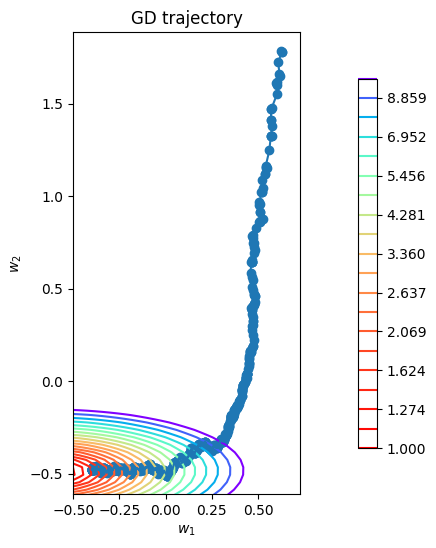


Learning rate = 0.0001 batch size = 10


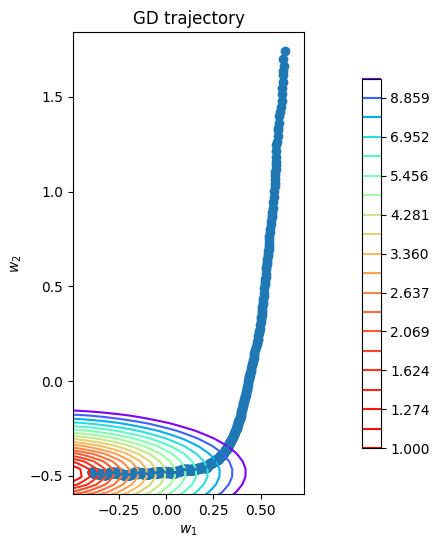


Learning rate = 0.0001 batch size = 20


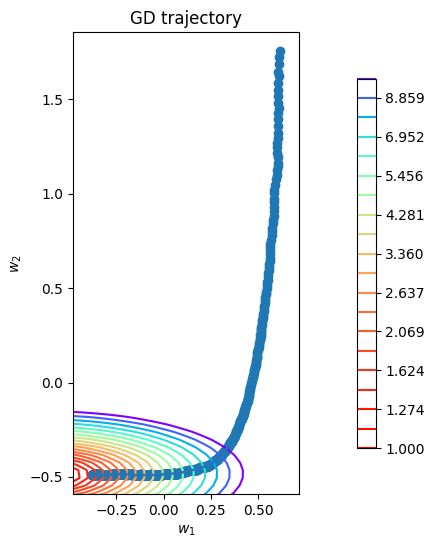


Learning rate = 0.0001 batch size = 100


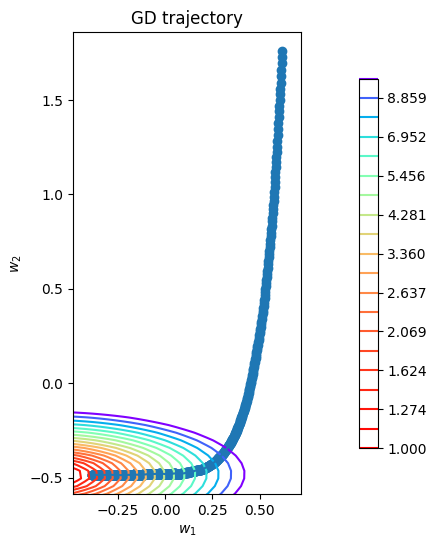


Learning rate = 0.0001 batch size = 200


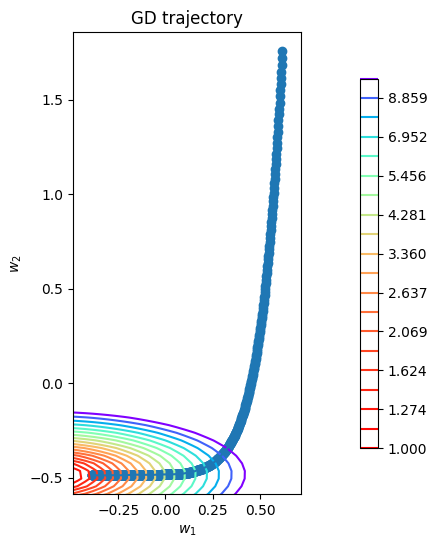


Learning rate = 0.0005 batch size = 1


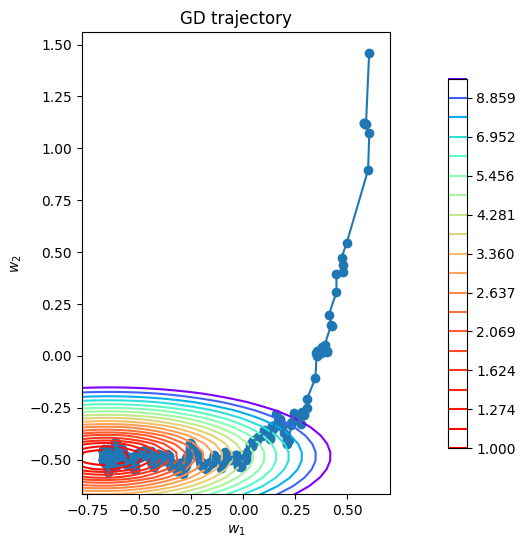


Learning rate = 0.0005 batch size = 10


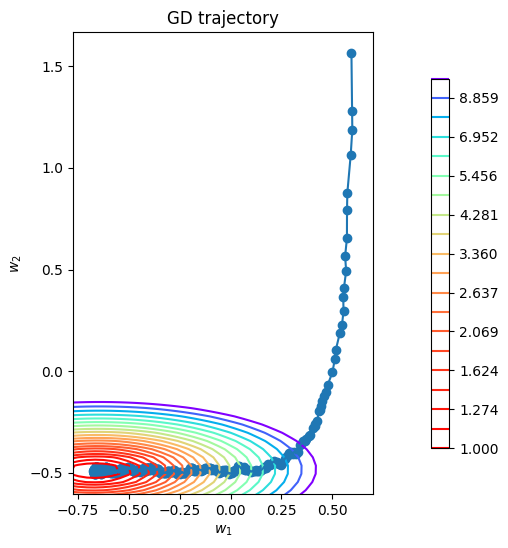


Learning rate = 0.0005 batch size = 20


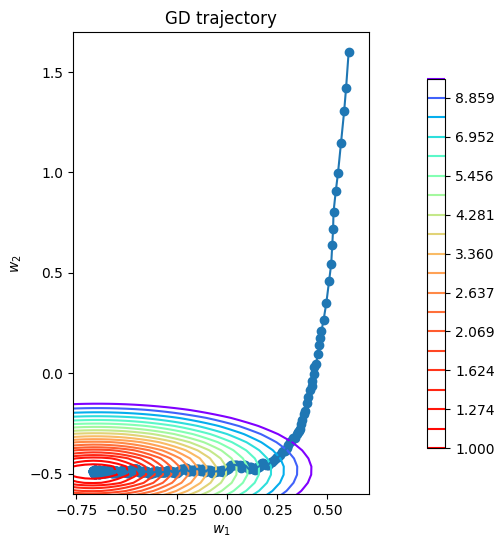


Learning rate = 0.0005 batch size = 100


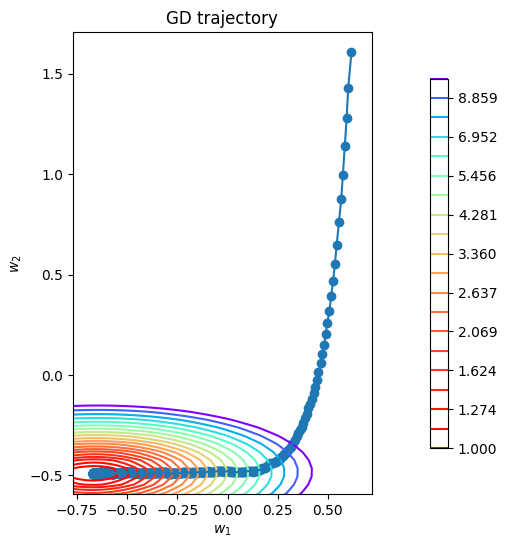


Learning rate = 0.0005 batch size = 200


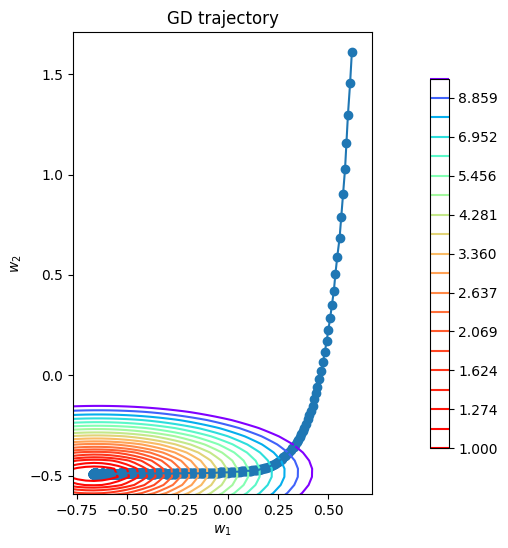


Learning rate = 0.001 batch size = 1


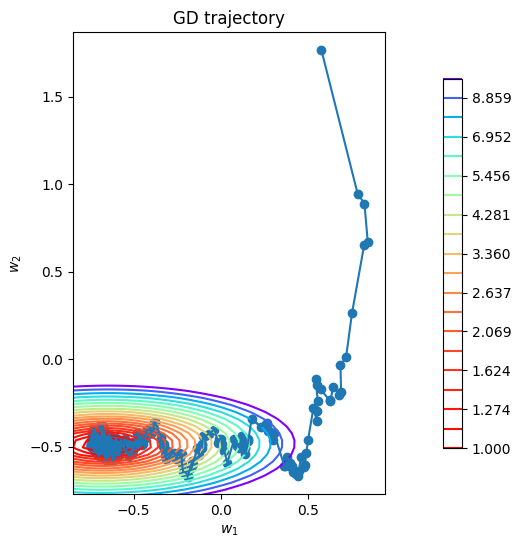


Learning rate = 0.001 batch size = 10


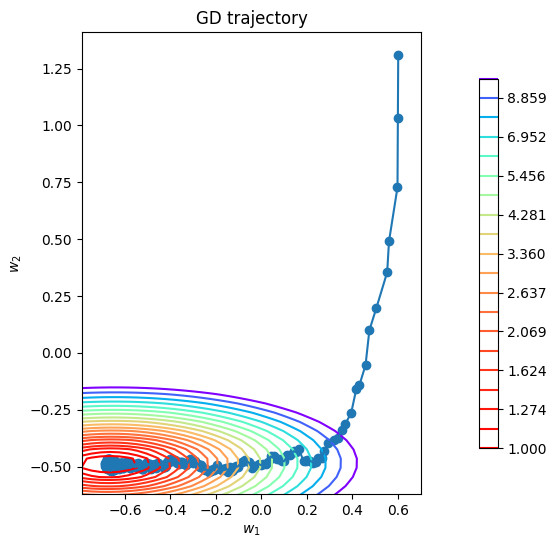


Learning rate = 0.001 batch size = 20


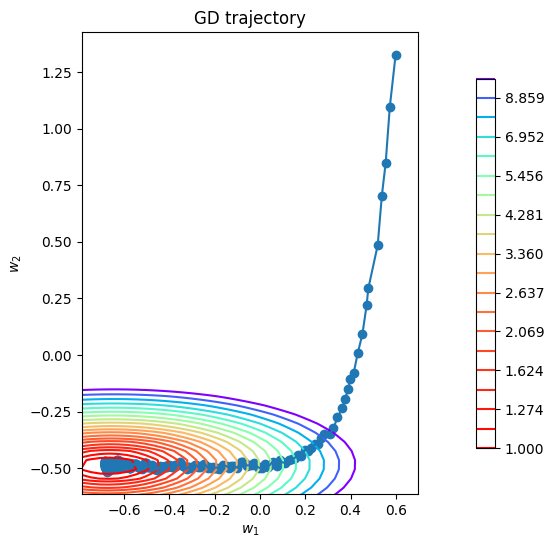


Learning rate = 0.001 batch size = 100


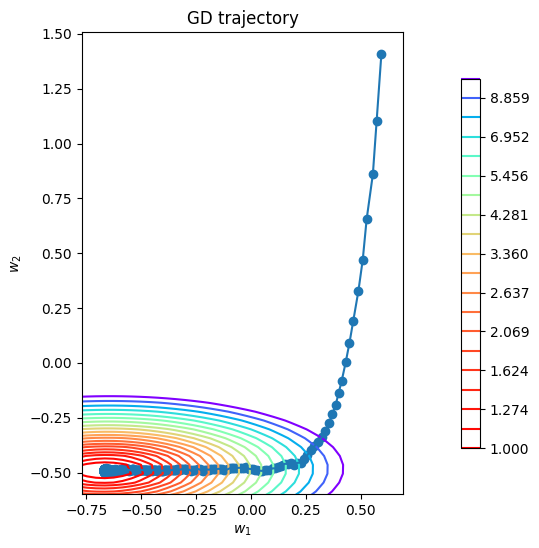


Learning rate = 0.001 batch size = 200


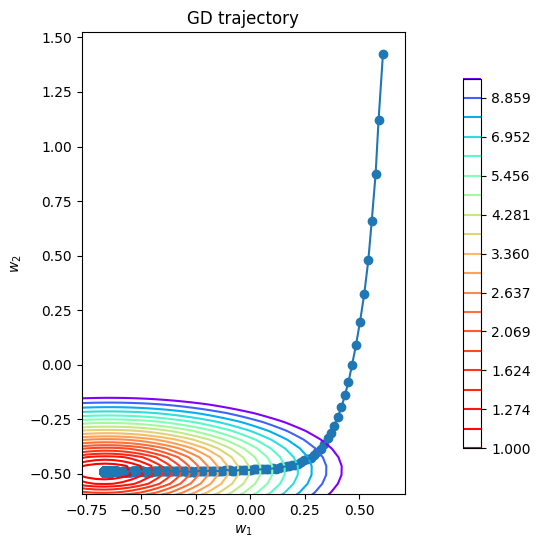


Learning rate = 0.005 batch size = 1


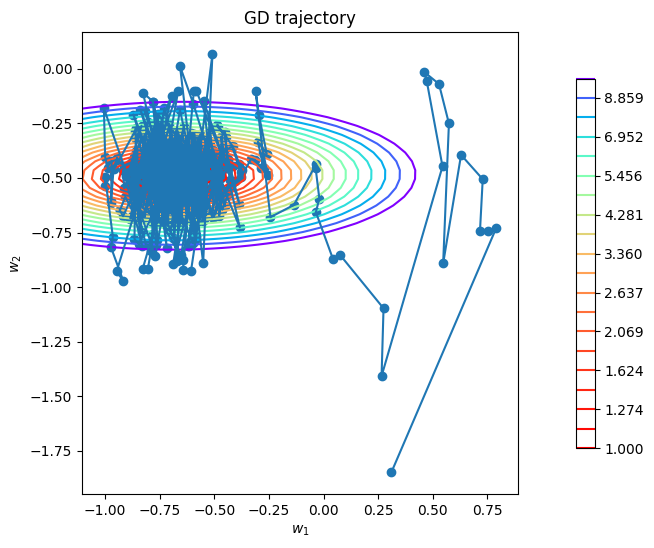


Learning rate = 0.005 batch size = 10


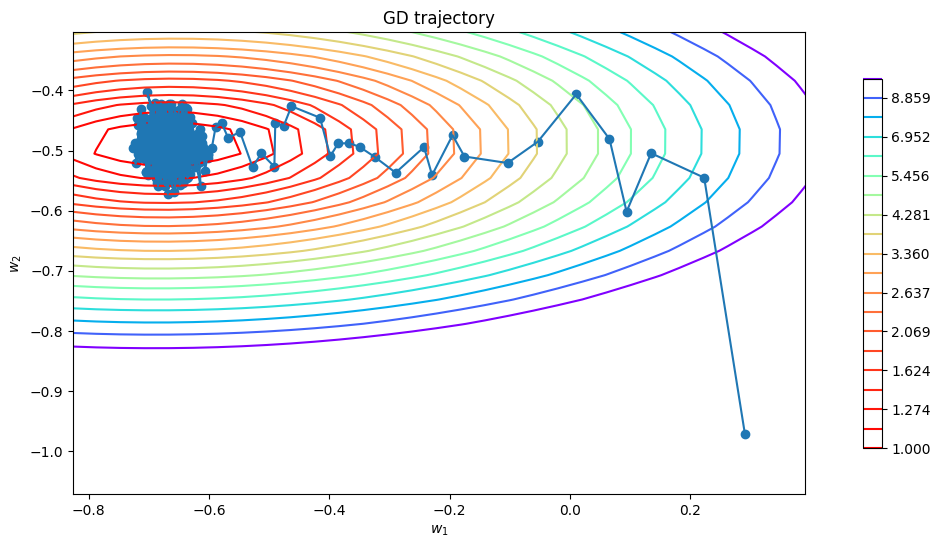


Learning rate = 0.005 batch size = 20


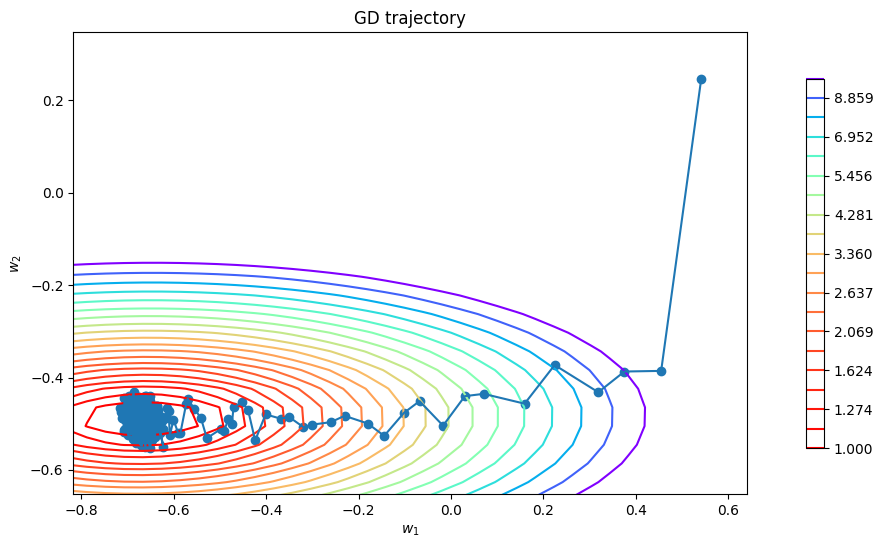


Learning rate = 0.005 batch size = 100


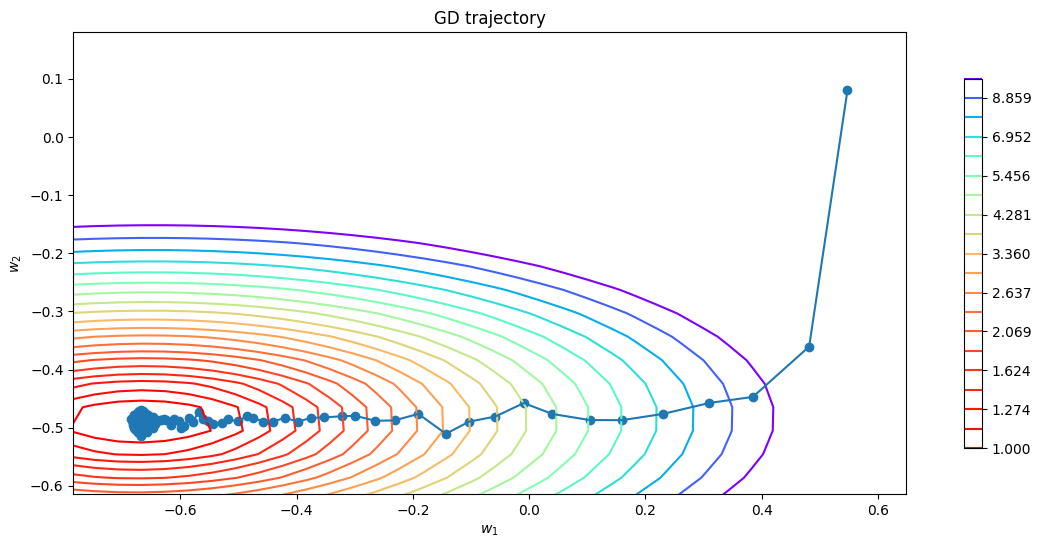


Learning rate = 0.005 batch size = 200


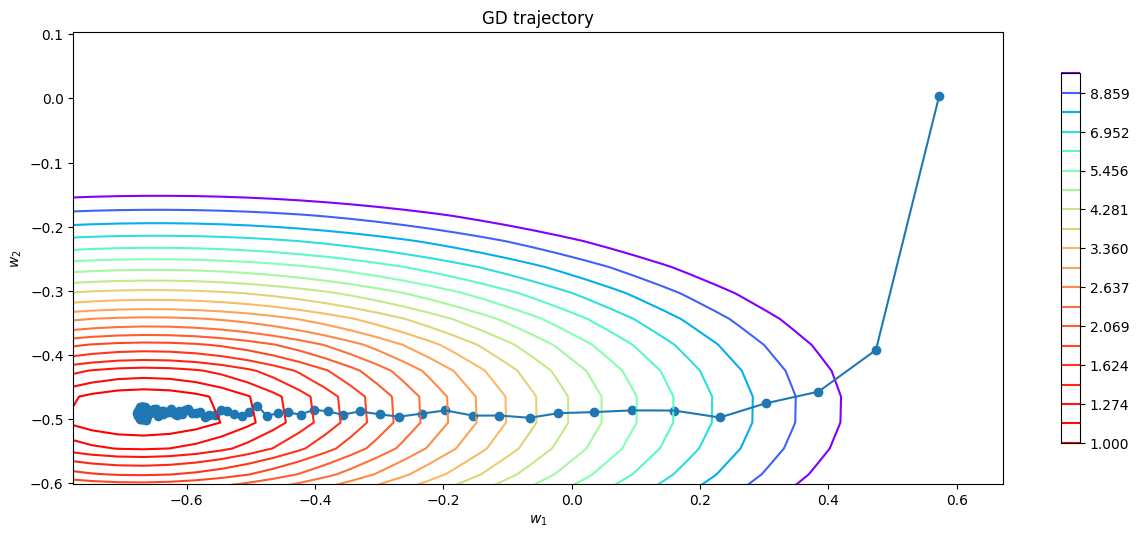


Learning rate = 0.01 batch size = 1


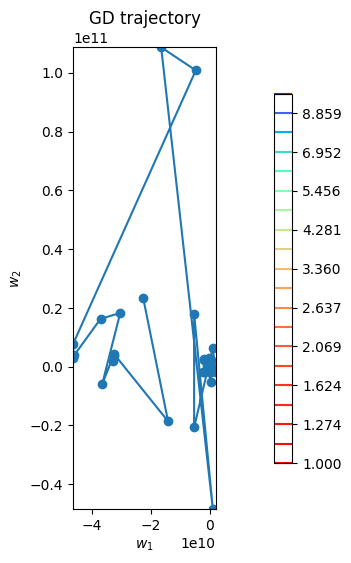


Learning rate = 0.01 batch size = 10


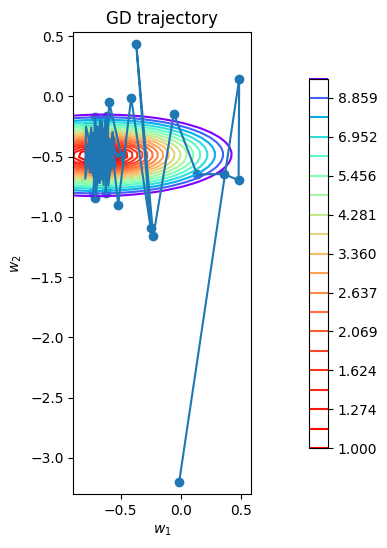


Learning rate = 0.01 batch size = 20


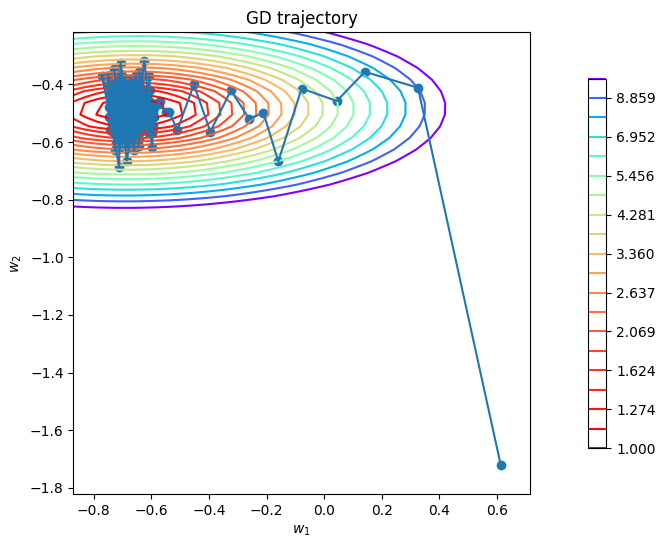


Learning rate = 0.01 batch size = 100


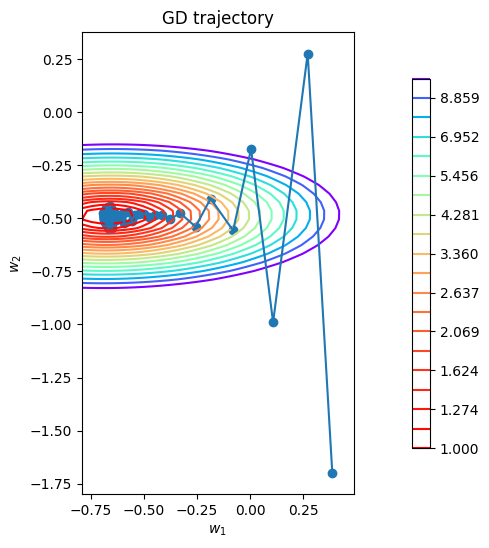


Learning rate = 0.01 batch size = 200


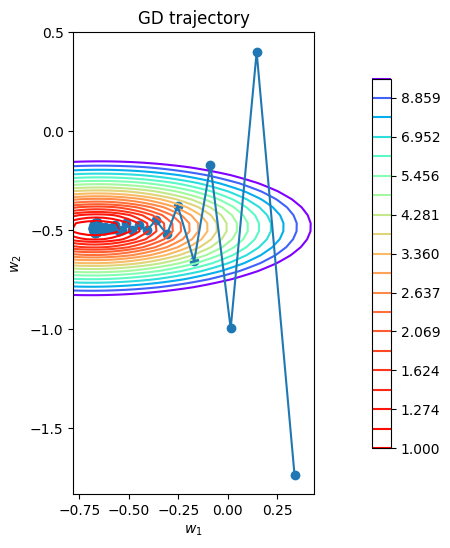

In [ ]:
for lr in [0.0001, 0.0005, 0.001, 0.005, 0.01]:
  for batch_size in [1, 10, 20, 100, 200]:
    w_list = stochastic_gradient_descent(w_init, X, y, MSELoss(), lr, batch_size)
    print('Learning rate =', lr, 'batch size =', batch_size)
    plot_gd(w_list, X, y, MSELoss())
    print()

Для каждого нового значения lr видим, что траектория становится более ровной с увеличением размера батча

- видно, что колбасит больше при большем lr и меньшем batch_size (самый тяжелый случай: learning rate = 0.01, batch size = 1)
- чем больше размер батча при каждом значении lr, тем больше траектория похожа на траекторию обычного градиентного спуска

Отличие SGD от GD в более неаккуратной траектории

- траектория SGD выглядит как траектория «пьяного человека», градиентный спуск колбасит, так как считается не «честный» градиент (а градиент для случайной выборки)
- при этом по началу в целом движение в сторону минимума, но в окрестности минимума сильно колбасит, поэтому не попадаем в точку минимума

**1.6 Реализация функции `stochastic_gradient_descent` с затухающим шагом**

Поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже уже хотим делать шаги маленькие, чтобы более точно этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = w_init
    w_trajectory = []
    for i in range(n_iterations):
      batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
      batch = X[batch_indices]
      y_batch = y[batch_indices]
      grad = loss.calc_grad(batch, y_batch, w)
      lr_t = lr * (1 / (1 + (i + 1)))**p                                          # добавила 1, т.к. i начинается с 0 (или for i in range(1, n_iterations + 1))
      w = w - lr_t * grad
      w_trajectory.append(w)
    return w_trajectory

**1.7 Отрисовка траектории градиентного спуска для разных значений параметра `p`**


p value 0.1


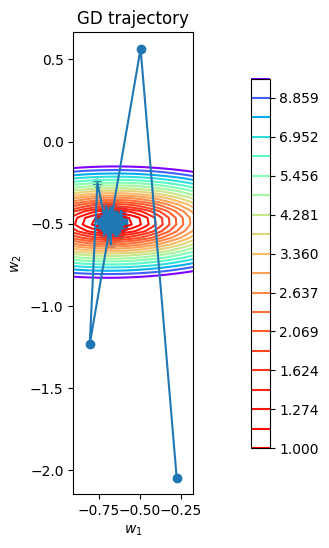


p value 0.2


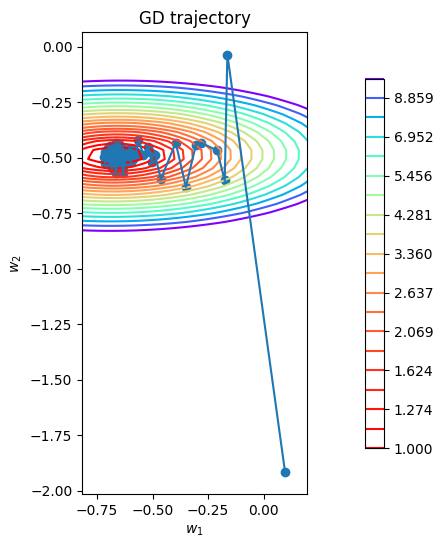


p value 0.3


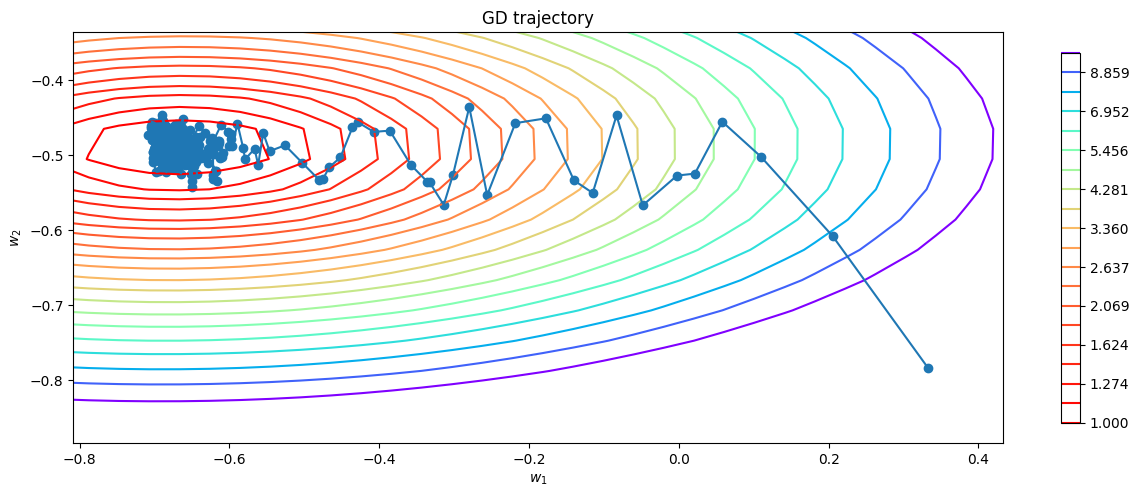


p value 0.4


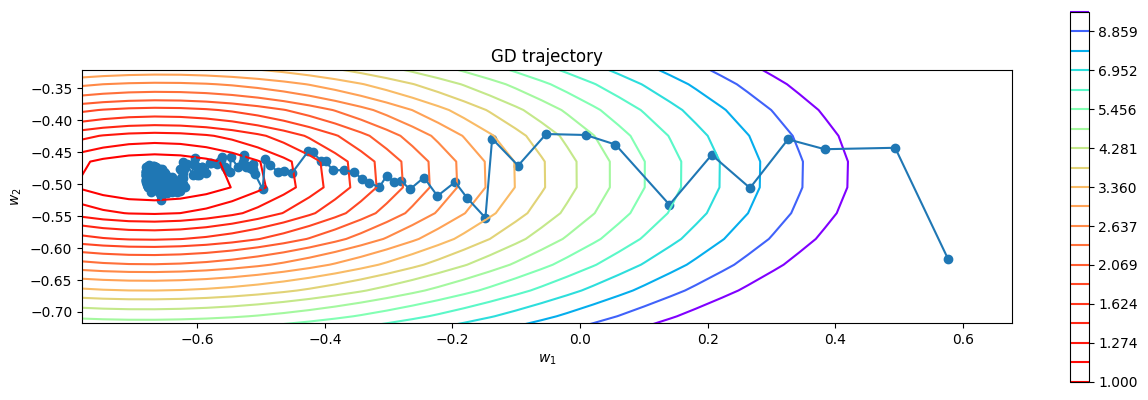


p value 0.5


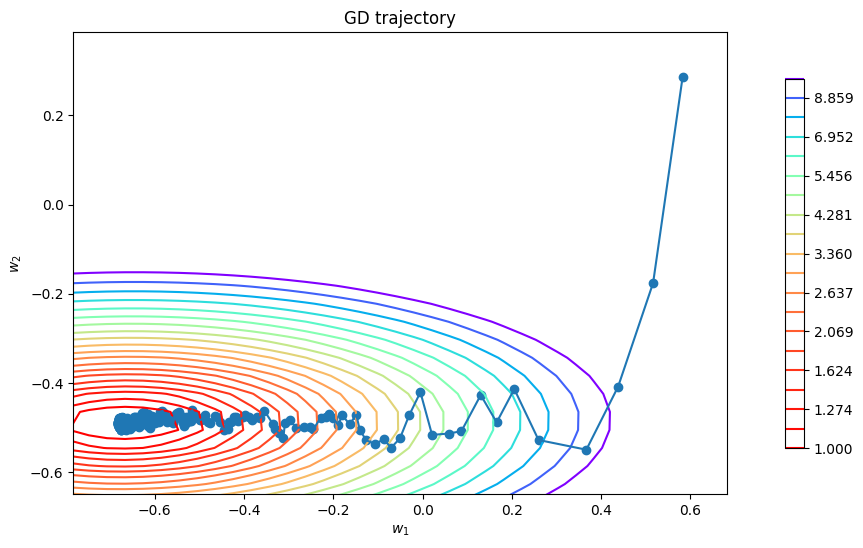


p value 1


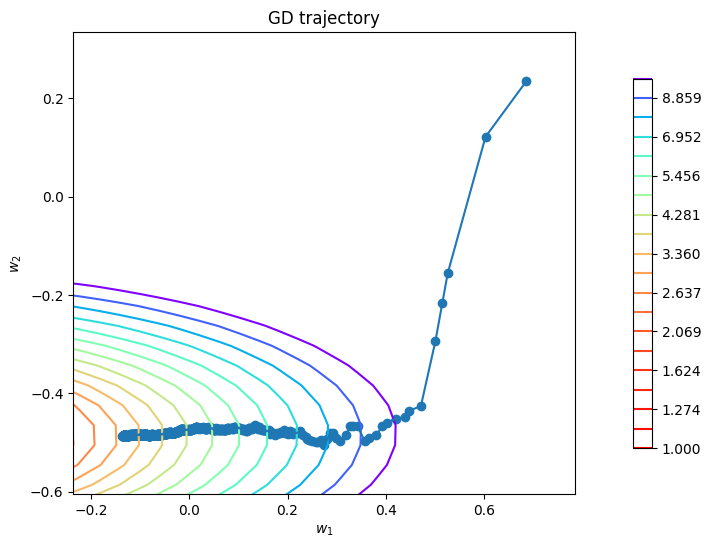

In [ ]:
for p in [0.1, 0.2, 0.3, 0.4, 0.5, 1]:
  w_list = stochastic_gradient_descent(w_init, X, y, MSELoss(), 0.01, 10, p)
  print('p value', p)
  plot_gd(w_list, X, y, MSELoss())
  print()

- чем больше параметр p, тем быстрее градиентный шаг уменьшается (что на самом деле очевидно из формулы) и траектория становится более гладкой
- при бОльших значениях параметра p в окрестности минимума градиентный спуск колеблется меньше и не "перепрыгивает" минимум

**1.8 Сравнение сходимости обычного градиентного спуска и стохастической версии по графику зависимости значения лосса от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами**

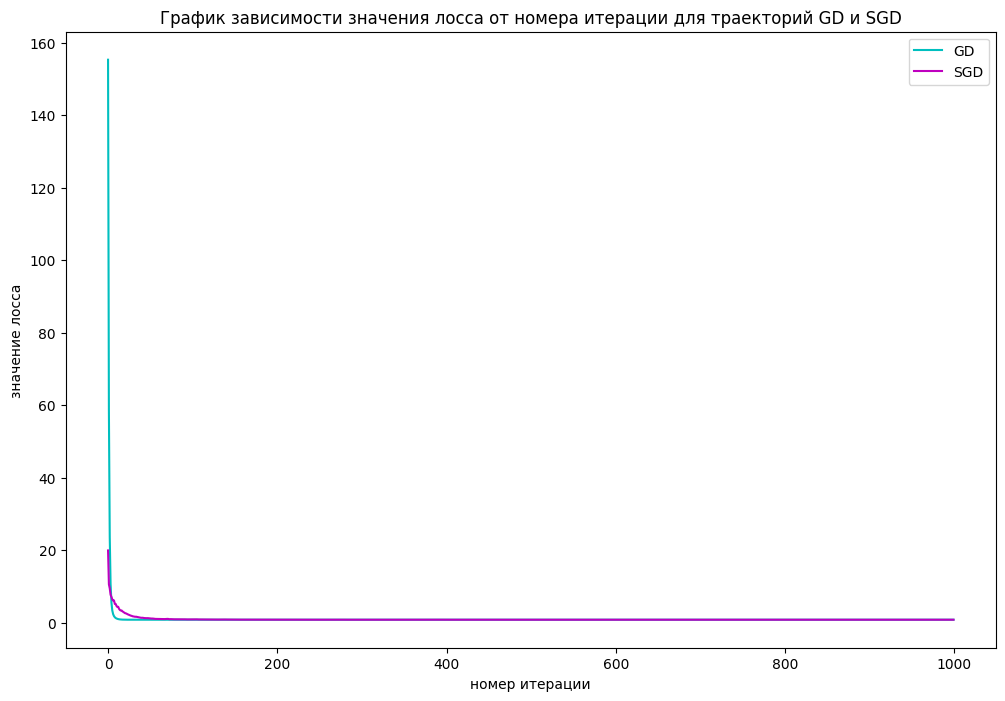

In [ ]:
np.random.seed(28)
loss = MSELoss()
w_list_GD = gradient_descent(w_init, X, y, loss, 0.01, 1000)
w_list_SGD = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, 0.5, 1000)
losses_GD = []
losses_SGD = []
iterations = []

for i in range(1000):
  losses_GD.append(loss.calc_loss(X, y, w_list_GD[i]))                            # считаем лосс на каждой итерации для GD
  losses_SGD.append(loss.calc_loss(X, y, w_list_SGD[i]))                          # и для SGD
  iterations.append(i)

plt.figure(figsize=(12, 8))
plt.plot(iterations, losses_GD, color='c')
plt.plot(iterations, losses_SGD, color='m')
plt.legend(['GD', 'SGD'])
plt.title('График зависимости значения лосса от номера итерации для траекторий GD и SGD')
plt.xlabel('номер итерации')
plt.ylabel('значение лосса')
plt.show()

Линии, соответствующие лоссу на выборке в зависимости от номера итерации, похожи друг на друга, идут примерно одинаково, т.к. все параметры одинаковые (линия SGD лежит даже выше, потому что с точки зрения улучшения качества на выборке SGD хуже, так как он движется в сторону уменьшения ошибки на подвыборке).

Главное преимущество SGD в том, что несмотря на то, что ему понадобится больше итераций (у SGD хуже сходимость), каждая итерация будет сильно более быстрой и он придет в минимум намного быстрее GD. Это преимущество нельзя увидеть на таком графике, потому что он не показывает время выполнения каждой операции.

#### 2. Линейная регрессия

**2.1 Реализация класса `LinearRegression`**

In [ ]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss  # объект лосса передаётся в момент инициализации; параметр loss позволяет управлять тем, какую функцию потерь оптимизируем
        self.lr = lr

    # подбор весов при помощи градиентного спуска
    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        w_init = np.random.uniform(-2, 2, (X.shape[1]))                           # initializing weights
        w_list = gradient_descent(w_init, X, y, self.loss, self.lr)               # performing gradient descent
        self.w = w_list[-1]                                                       # memorizing weights from the last iteration
        return self

    # применение регрессии к датасету и возвращение вектора ответов
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        return X.dot(self.w)                                                      # returning vector of targets Xw

In [ ]:
# создание объекта линейной регрессии для MSELoss
linear_regression = LinearRegression(MSELoss())

Применение регрессии на реальном датасете. Загрузка датасета с машинами:

In [ ]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [ ]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

In [ ]:
X_raw

index  0      1            2       3      4     5            6    7  \
0        0  3    NaN  alfa-romero     gas    std   two  convertible  rwd   
1        1  3    NaN  alfa-romero     gas    std   two  convertible  rwd   
2        2  1    NaN  alfa-romero     gas    std   two    hatchback  rwd   
3        3  2  164.0         audi     gas    std  four        sedan  fwd   
4        4  2  164.0         audi     gas    std  four        sedan  4wd   
..     ... ..    ...          ...     ...    ...   ...          ...  ...   
196    200 -1   95.0        volvo     gas    std  four        sedan  rwd   
197    201 -1   95.0        volvo     gas  turbo  four        sedan  rwd   
198    202 -1   95.0        volvo     gas    std  four        sedan  rwd   
199    203 -1   95.0        volvo  diesel  turbo  four        sedan  rwd   
200    204 -1   95.0        volvo     gas  turbo  four        sedan  rwd   

         8  ...    15   16    17    18    19    20     21      22  23  24  
0    front  ...  four  130  mpfi  3.47  2.68   9.0  111.0  5000.0  21  27  
1    front  ...  four  130  mpfi  3.47  2.68   9.0  111.0  5000.0  21  27  
2    front  ...   six  152  mpfi  2.68  3.47   9.0  154.0  5000.0  19  26  
3    front  ...  four  109  mpfi  3.19  3.40  10.0  102.0  5500.0  24  30  
4    front  ...  five  136  mpfi  3.19  3.40   8.0  115.0  5500.0  18  22  
..     ...  ...   ...  ...   ...   ...   ...   ...    ...     ...  ..  ..  
196  front  ...  four  141  mpfi  3.78  3.15   9.5  114.0  5400.0  23  28  
197  front  ...  four  141  mpfi  3.78  3.15   8.7  160.0  5300.0  19  25  
198  front  ...   six  173  mpfi  3.58  2.87   8.8  134.0  5500.0  18  23  
199  front  ...   six  145   idi  3.01  3.40  23.0  106.0  4800.0  26  27  
200  front  ...  four  141  mpfi  3.78  3.15   9.5  114.0  5400.0  19  25  

[201 rows x 26 columns]

**2.2 Обработка датасета (подготовка для обучения линейной регрессии)**

In [ ]:
X_raw = X_raw.drop('index', axis=1)                                               # dropping column 'index'
X_raw.head()

0      1            2    3    4     5            6    7      8     9   ...  \
0   3    NaN  alfa-romero  gas  std   two  convertible  rwd  front  88.6  ...   
1   3    NaN  alfa-romero  gas  std   two  convertible  rwd  front  88.6  ...   
2   1    NaN  alfa-romero  gas  std   two    hatchback  rwd  front  94.5  ...   
3   2  164.0         audi  gas  std  four        sedan  fwd  front  99.8  ...   
4   2  164.0         audi  gas  std  four        sedan  4wd  front  99.4  ...   

     15   16    17    18    19    20     21      22  23  24  
0  four  130  mpfi  3.47  2.68   9.0  111.0  5000.0  21  27  
1  four  130  mpfi  3.47  2.68   9.0  111.0  5000.0  21  27  
2   six  152  mpfi  2.68  3.47   9.0  154.0  5000.0  19  26  
3  four  109  mpfi  3.19  3.40  10.0  102.0  5500.0  24  30  
4  five  136  mpfi  3.19  3.40   8.0  115.0  5500.0  18  22  

[5 rows x 25 columns]

Разделение датасета на обучающую и тестовую выборку

In [ ]:
# splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=28)

Заполнение пропусков и нормализация числовых признаков

In [ ]:
X_train.isna().any().any()

True

In [ ]:
X_test.isna().any().any()

True

In [ ]:
# filling the gaps (NA) and normalizing numeric features
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

replacer = SimpleImputer(strategy="mean")
normalizer = StandardScaler()

# train
mask_train = (X_train.dtypes == "object").values                                  # creating mask of categorial features

X_num_train = X_train[X_train.columns[~mask_train]]                               # numeric features
X_num_train = pd.DataFrame(data=replacer.fit_transform(X_num_train), columns=X_num_train.columns)   # filling the gaps for numeric features with mean values
X_num_train = pd.DataFrame(data=normalizer.fit_transform(X_num_train), columns=X_num_train.columns, index=X_train.index.to_list()) # normalizing numeric features

X_obj_train = X_train[X_train.columns[mask_train]].fillna("")                     # filling the gaps for categorial features with empty strings

X_train = pd.concat([X_num_train, X_obj_train], axis=1)                           # concating two dataframes

# test
mask_test = (X_test.dtypes == "object").values                                    # creating mask of categorial features

X_num_test = X_test[X_test.columns[~mask_test]]                                   # numeric features
X_num_test = pd.DataFrame(data=replacer.transform(X_num_test), columns=X_num_test.columns)   # filling the gaps for numeric features with mean values
X_num_test = pd.DataFrame(data=normalizer.transform(X_num_test), columns=X_num_test.columns, index=X_test.index.to_list()) # normalizing numeric features

X_obj_test = X_test[X_test.columns[mask_test]].fillna("")                         # filling the gaps for categorial features with empty strings

X_test = pd.concat([X_num_test, X_obj_test], axis=1)                             # concating two dataframes

In [ ]:
X_train.head()

0             1         9         10        11        12        13  \
11  -0.678931  1.823287e+00  0.377399  0.192774 -0.544396  0.251637  0.260713   
183  0.905242 -1.004419e+00 -0.261150 -0.220685 -0.219285  0.826473 -0.505044   
79   1.697328 -4.274906e-16 -0.490373 -0.099079  0.152272 -1.431811  0.501603   
52   1.697328  6.801722e-01 -0.588611 -0.439575 -0.126395 -1.678169 -0.385578   
14  -0.678931 -4.274906e-16  0.753979  1.181831  0.430939  0.826473  1.279111   

           16        18        19  ...          2       3      4     5   \
11   0.865206 -0.060724 -0.213293  ...         bmw     gas    std   two   
183 -0.741850 -1.130503  0.435996  ...  volkswagen  diesel  turbo  four   
79   0.673319  0.902077  1.858247  ...  mitsubishi     gas  turbo   two   
52  -1.389469  0.000000  0.000000  ...       mazda     gas    std   two   
14   1.944572  1.044714  0.405077  ...         bmw     gas    std  four   

            6    7      8      14    15    17  
11       sedan  rwd  front    ohc   six  mpfi  
183      sedan  fwd  front    ohc  four   idi  
79   hatchback  fwd  front    ohc  four  spdi  
52   hatchback  rwd  front  rotor   two  4bbl  
14       sedan  rwd  front    ohc   six  mpfi  

[5 rows x 25 columns]

In [ ]:
X_train.isna().any().any()

False

In [ ]:
X_test.head()

0         1         9         10        11        12        13  \
67  -1.471017 -1.034501  2.735118  2.284387  2.660276  1.072832  2.336678   
24   0.113155  0.620008 -0.850580 -1.388097 -1.008841 -1.267572 -1.151336   
170 -1.471017 -1.876796  0.573875  0.095489  0.245161  0.497996 -0.189733   
65  -1.471017 -1.034501  1.818227  1.335865  2.010053  2.058265  2.297509   
61  -0.678931 -0.372697 -0.015554  0.273844  0.245161  0.744354 -0.297448   

           16        18        19  ...             2       3      4     5   \
67   1.320938  0.902077  1.178040  ...  mercedes-benz  diesel  turbo  four   
24  -0.909751 -1.273140 -0.089619  ...          dodge     gas    std  four   
170 -0.430033 -0.203361  0.281403  ...         toyota  diesel  turbo  four   
65   1.320938  0.902077  1.178040  ...  mercedes-benz  diesel  turbo  four   
61  -0.142202  0.224550  0.405077  ...          mazda     gas    std  four   

            6    7      8    14    15    17  
67       sedan  rwd  front  ohc  five   idi  
24       sedan  fwd  front  ohc  four  2bbl  
170      sedan  fwd  front  ohc  four   idi  
65       wagon  rwd  front  ohc  five   idi  
61   hatchback  fwd  front  ohc  four  2bbl  

[5 rows x 25 columns]

In [ ]:
X_test.isna().any().any()

False

Кодирование категориальных переменных

In [ ]:
# converting column names into strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# encoding the categorial features
enc = OneHotEncoder(drop='first', sparse_output=False, handle_unknown = 'ignore')
ohe = ColumnTransformer(
    transformers=[('ohe', enc, ['2', '3', '4', '5', '6', '7', '8', '14', '15', '17']),],
    remainder='passthrough',
)
ohe.set_output(transform='pandas')

X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [ ]:
X_train.head()

ohe__2_audi  ohe__2_bmw  ohe__2_chevrolet  ohe__2_dodge  ohe__2_honda  \
11           0.0         1.0               0.0           0.0           0.0   
183          0.0         0.0               0.0           0.0           0.0   
79           0.0         0.0               0.0           0.0           0.0   
52           0.0         0.0               0.0           0.0           0.0   
14           0.0         1.0               0.0           0.0           0.0   

     ohe__2_isuzu  ohe__2_jaguar  ohe__2_mazda  ohe__2_mercedes-benz  \
11            0.0            0.0           0.0                   0.0   
183           0.0            0.0           0.0                   0.0   
79            0.0            0.0           0.0                   0.0   
52            0.0            0.0           1.0                   0.0   
14            0.0            0.0           0.0                   0.0   

     ohe__2_mercury  ...  remainder__12  remainder__13  remainder__16  \
11              0.0  ...       0.251637       0.260713       0.865206   
183             0.0  ...       0.826473      -0.505044      -0.741850   
79              0.0  ...      -1.431811       0.501603       0.673319   
52              0.0  ...      -1.678169      -0.385578      -1.389469   
14              0.0  ...       0.826473       1.279111       1.944572   

     remainder__18  remainder__19  remainder__20  remainder__21  \
11       -0.060724      -0.213293      -0.254911       0.376404   
183      -1.130503       0.435996       3.476146      -0.991334   
79        0.902077       1.858247      -0.787919       0.995757   
52        0.000000       0.000000      -0.148310      -0.139723   
14        1.044714       0.405077      -0.521415       1.950593   

     remainder__22  remainder__23  remainder__24  
11       -1.992822      -0.579012      -0.330153  
183      -1.464022       1.882064       1.724130  
79       -0.406421      -0.886647      -0.917091  
52        1.708781      -1.194281      -1.063825  
14        0.439660      -1.348099      -1.210559  

[5 rows x 64 columns]

In [ ]:
X_test.head()

ohe__2_audi  ohe__2_bmw  ohe__2_chevrolet  ohe__2_dodge  ohe__2_honda  \
67           0.0         0.0               0.0           0.0           0.0   
24           0.0         0.0               0.0           1.0           0.0   
170          0.0         0.0               0.0           0.0           0.0   
65           0.0         0.0               0.0           0.0           0.0   
61           0.0         0.0               0.0           0.0           0.0   

     ohe__2_isuzu  ohe__2_jaguar  ohe__2_mazda  ohe__2_mercedes-benz  \
67            0.0            0.0           0.0                   1.0   
24            0.0            0.0           0.0                   0.0   
170           0.0            0.0           0.0                   0.0   
65            0.0            0.0           0.0                   1.0   
61            0.0            0.0           1.0                   0.0   

     ohe__2_mercury  ...  remainder__12  remainder__13  remainder__16  \
67              0.0  ...       1.072832       2.336678       1.320938   
24              0.0  ...      -1.267572      -1.151336      -0.909751   
170             0.0  ...       0.497996      -0.189733      -0.430033   
65              0.0  ...       2.058265       2.297509       1.320938   
61              0.0  ...       0.744354      -0.297448      -0.142202   

     remainder__18  remainder__19  remainder__20  remainder__21  \
67        0.902077       1.178040       3.076390       0.428017   
24       -1.273140      -0.089619      -0.148310      -0.991334   
170      -0.203361       0.281403       3.342894      -0.862302   
65        0.902077       1.178040       3.076390       0.428017   
61        0.224550       0.405077      -0.361513      -0.578431   

     remainder__22  remainder__23  remainder__24  
67       -1.781302      -0.425195      -0.770356  
24        0.651180       0.959161       1.137192  
170      -1.464022       0.805343       0.403520  
65       -1.781302      -0.425195      -0.770356  
61       -0.829461       0.190074       0.256785  

[5 rows x 64 columns]

**2.3 Обучение линейной регрессии**

In [ ]:
np.random.seed(28)
linear_regression = LinearRegression(MSELoss())
lr = linear_regression.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error

print(f"Train: {mean_squared_error(y_train, lr.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, lr.predict(X_test))}")

Train: 1383095.4023828937
Test: 6934150.165180113


**2.4 Реализация класса `MSEL2Loss`**

Модель переобучилась. Добавим L2 регуляризацию.

Формула функции потерь для MSE с L2 регуляризацией:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

В матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

In [ ]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        return np.square(X.dot(w) - y).mean() + self.coef * np.sum(np.square(w[:-1])) # убираем последний элемент из w, т.к. последний элемент вектора w — это bias, его регуляризовать не нужно

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w (значения вектора градиента)
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        grad_1 = 2 * X.T.dot(X.dot(w) - y) / X.shape[0]                           # calculate the first part of the gradient
        bias = w[-1]
        w[-1] = 0                                                                 # nullify the last weight (bias isn't supposed to be regularized)
        grad_2 = 2 * self.coef * w                                                # calculate the second part of the gradient
        w[-1] = bias
        return grad_1 + grad_2                                                    # sum two parts

In [ ]:
# создание объекта линейной регрессии для MSELoss с L2 регуляризацией
linear_regression = LinearRegression(MSEL2Loss(0.1))

**2.5 Обучение регрессии с лоссом `MSEL2Loss`, подбор оптимального коэффициента регуляризации для улучшения результата на тестовой выборке**

In [ ]:
np.random.seed(28)
for coef in [0, 0.0001, 0.001, 0.0015, 0.01, 0.1]:
  linear_regression = LinearRegression(MSEL2Loss(coef))
  lr = linear_regression.fit(X_train, y_train)
  print(coef)
  print(f"Train: {mean_squared_error(y_train, lr.predict(X_train))}")
  print(f"Test: {mean_squared_error(y_test, lr.predict(X_test))}")
  print()

# лучший коэффициент - 0.001, ошибка на трейне немного выросла, не тесте немного уменьшилась (по сравнению с регрессией без регуляризации)

0
Train: 1383095.4023828937
Test: 6934150.165180113

0.0001
Train: 1400855.936084944
Test: 6168099.627057021

0.001
Train: 1538308.755293008
Test: 5514678.40749073

0.0015
Train: 1600884.2542276212
Test: 5558032.698120003

0.01
Train: 2437845.52850575
Test: 6915315.6356960945

0.1
Train: 5177568.69494488
Test: 9951592.645183176



**2.6 Реализация класса `HuberLoss`**

В датасете могут быть выбросы. С выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE.

Функция потерь Huber Loss:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


Градиент:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

In [ ]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        delta = X.dot(w) - y
        loss = np.zeros_like(y)
        mask = (-self.eps < delta) & (delta < self.eps)
        loss[mask] = (1/2) * np.square(delta[mask])
        loss[~mask] = self.eps * (np.abs(delta[~mask]) - (1/2) * self.eps)
        return loss.mean()

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w (значения вектора градиента)
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        delta = X.dot(w) - y
        grad = np.zeros_like(y)
        mask = (-self.eps < delta) & (delta < self.eps)
        grad[mask] = delta[mask]
        grad[~mask] = self.eps * np.sign(delta[~mask])
        return X.T.dot(grad) / X.shape[0]

**2.7 Обучение регрессии с лоссом `HuberLoss`**

In [ ]:
np.random.seed(28)
for eps in [0.01, 0.1, 10, 100, 115, 120, 125]:
  linear_regression = LinearRegression(HuberLoss(eps))
  lr = linear_regression.fit(X_train, y_train)
  print(eps)
  print(f"Train: {mean_squared_error(y_train, lr.predict(X_train))}")
  print(f"Test: {mean_squared_error(y_test, lr.predict(X_test))}")
  print()

# лучшее значение параметра eps - 100 (Train: 2218492.448821149   Test: 5526500.671549722)
# на MSELoss было                      Train: 1383095.4023828937  Test: 6934150.165180113)
# стало лучше

0.01
Train: 231706222.3206722
Test: 211130204.23995903

0.1
Train: 143007599.8584289
Test: 132945378.98153041

10
Train: 4918330.672933367
Test: 10591618.802891847

100
Train: 2218492.448821149
Test: 5526500.671549722

115
Train: 2215390.818964537
Test: 5556192.645003373

120
Train: 2222507.1810380057
Test: 5569139.377314032

125
Train: 2228418.9808084997
Test: 5582864.651897186



#### 3. Алгоритм имитации отжига

["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0) — еще один метод оптимизации (не так часто используется для оптимизации моделей машинного обучения).

**Реализация алгоритма имитации отжига для оптимизации MSE линейной регрессии, сравнение результата с градиентным спуском по траектории и по финальному лоссу**

In [ ]:
def simulated_annealing(
    w: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    temp: float = 100,
    n_iterations: int = 10000,
) -> List[np.ndarray]:

    old_w = w
    energy_old = loss.calc_loss(X, y, old_w)
    w_trajectory = []

    for i in range(n_iterations):

      # каждая новая точка (веса регрессии в данном случае) семплируется из некоторого случайного распределением с центром в текущей точке
      # (чем больше параметр распределения, тем реже новые точки будут очень сильно уходить от старых)
      new_w = old_w + np.random.standard_t(2, size=old_w.shape)                   # (распределение Стьюдента с параметром количества степеней свободы в районе 2)
      energy_new = loss.calc_loss(X, y, new_w)
      delta = energy_new - energy_old

      if delta <= 0:
        old_w = new_w
        energy_old = energy_new

      else:
        prob = np.exp(-delta / temp)

        if np.random.rand() < prob:
          old_w = new_w
          energy_old = energy_new

      temp = 0.95 * temp

      w_trajectory.append(old_w)
    return w_trajectory

In [ ]:
class LinearRegression_SimulatedAnnealing:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        w_init = np.random.uniform(-2, 2, (X.shape[1]))                           # initializing weights
        w_list = simulated_annealing(w_init, X, y, self.loss, self.lr)            # performing simulated annealing
        self.w = w_list[-1]                                                       # memorizing weights from the last iteration
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        return X.dot(self.w)                                                      # returning vector of targets Xw

In [ ]:
np.random.seed(28)
linear_regression = LinearRegression_SimulatedAnnealing(MSELoss())
lr = linear_regression.fit(X_train, y_train)

print(f"Train: {mean_squared_error(y_train, lr.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, lr.predict(X_test))}")

# ошибка и на трейне и на тесте сильно выросла, это логично, потому что при отжиге не всегда движемся в сторону уменьшения ошибки

Train: 7808965.15488009
Test: 11790896.42565958


In [ ]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


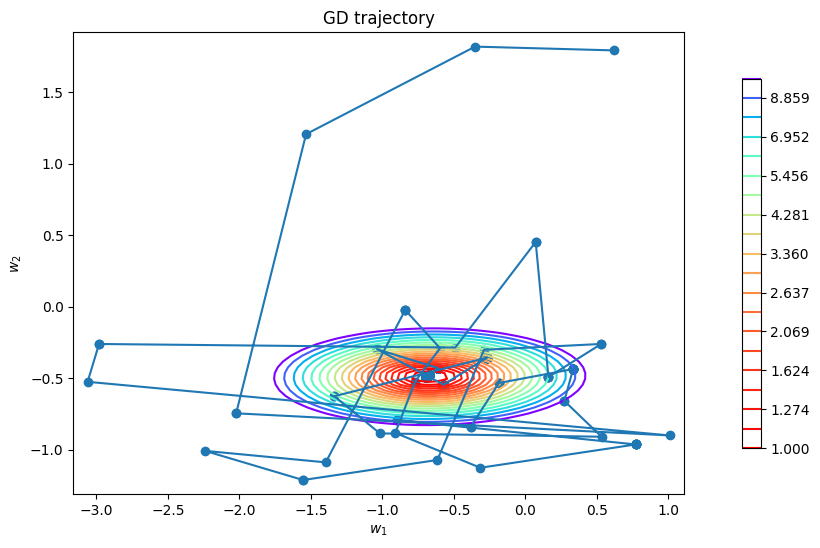

In [ ]:
np.random.seed(28)
w_list = simulated_annealing(w_init, X, y, MSELoss(), 0.1)
plot_gd(w_list, X, y, MSELoss())

# конечно, тут колбасит еще больше, чем на SGD, и уж тем более больше, чем на обычном градиентном спуске

In [ ]:
print(loss.calc_loss(X, y, w_list[-1]))
# значение лосса для последних весов из траекторий немного увеличилось (до этого было 0.8670644395649493)

0.8741699589015549


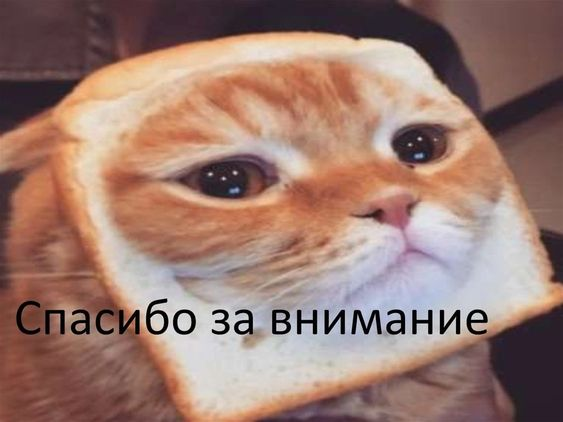

#### Some memes

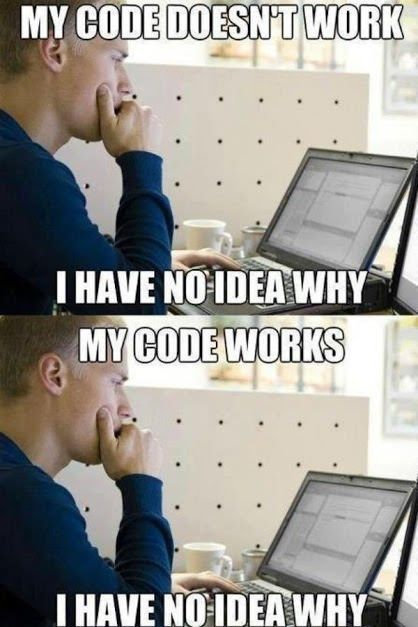

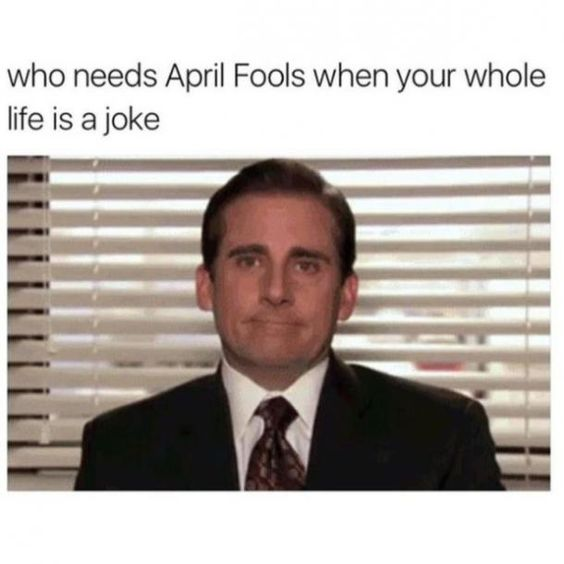

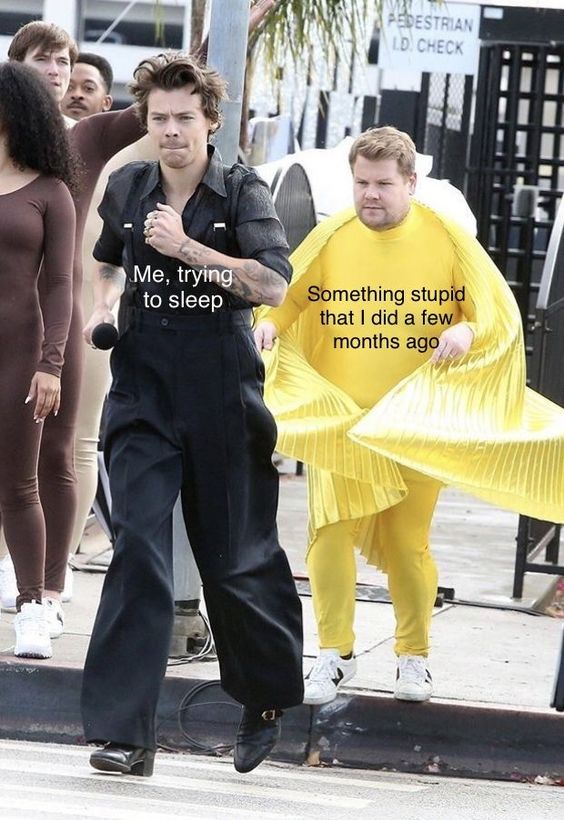